<a href="https://colab.research.google.com/github/saadam1n/CS4803-EML/blob/main/lab0/lab0_task2_Saad_Amin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pleas read:

before your start running this jupyter notebook, please click Edit > Notebook Settings and choose any of the available GPUs.

## 0. Import Python Packages

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: you may import more packages below:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import tqdm

import matplotlib.pyplot as plt

## 1. Define your first network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)

        return output

## 2. Implement training loop and test function

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    # TODO: finish this function, you are required to:
    # 1. implement model forward pass, backward pass and parameter update;
    # 2. return the training loss every 100 training steps;

    model.to(device)
    model.train()
    model.compile()

    loss_curve = []
    training_step = 0

    scaler = torch.amp.GradScaler()

    for epoch_idx in tqdm.tqdm(range(epoch)):
        for input, labels in train_loader:
            input = input.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type="cuda", dtype=torch.float16):
              logits = model(input)
              loss = F.nll_loss(logits, labels)



            scaler.scale(loss).backward()

            scaler.step(optimizer)
            scaler.update()

            if training_step % 100 == 0:
              loss_curve.append(loss.item())

            training_step += 1


    return model, loss_curve

def test(model, device, test_loader):
    # TODO: finish this function, you are required to:
    # 1. print the loss and classification accuracy on the test set
    model.eval()

    total_loss = 0.0
    num_batches = 0

    num_correct = 0
    num_total = 0

    for input, labels in test_loader:
        input = input.to(device)
        labels = labels.to(device)

        logits = model(input)

        loss = F.nll_loss(logits, labels)

        top1 = torch.argmax(logits, dim=1)

        num_correct += (top1 == labels).sum().item()
        num_total += top1.shape[0]

        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches
    print(f"Total test loss was {avg_loss}")

    print(f"Accuracy was {100 * num_correct / num_total}")


## 3. Dataset loading


In [ ]:
# TODO: finish the code here, you are required to:
# 1. load the training and testing split of the MNIST dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## 4. Put Everything Together

100%|██████████| 16/16 [04:07<00:00, 15.48s/it]


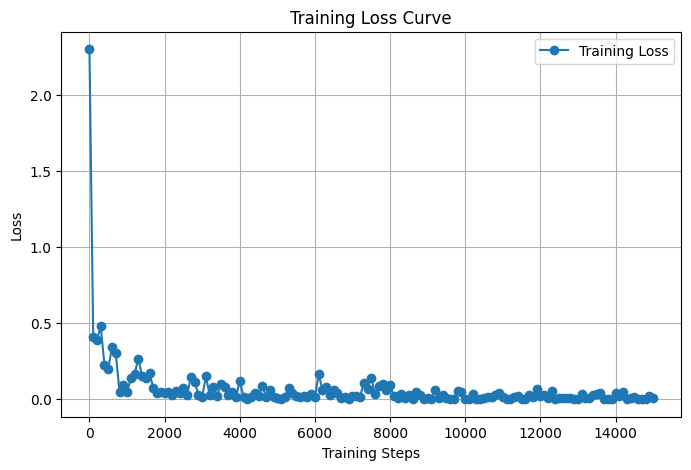

Total test loss was 0.027026370627749735
Accuracy was 99.16


In [ ]:
# TODO: finish the code here, you are required to:
# 1. launch model training: recommended hyperparameter: batch size = 64, learning rate = 1.0, adam optimizer
# 2. visualize the training loss curve using matplotlib or any other libraries
model = Net()
device = torch.device("cuda")
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

model, losses = train(model, device, train_loader, optimizer, 16)

steps = [i * 100 for i in range(len(losses))]

plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o', label="Training Loss")

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# run test
test(model, device, test_loader)